# Faster R-CNN

Now we train the Faster R-CNN model on the dataset.

## Load and test the model

As before, we start by loading the pre-trained model and making a prediction on a sample image.

Using device: cpu
Inference time: 1.1429 seconds
Detections:
Label: 1, Score: 1.000, Box: [1126.6041259765625, 517.5123291015625, 1435.5496826171875, 1299.656494140625]
Label: 3, Score: 0.999, Box: [1356.5489501953125, 580.2051391601562, 1638.4212646484375, 743.091064453125]
Label: 1, Score: 0.999, Box: [352.5533752441406, 511.9132080078125, 834.04345703125, 1355.4713134765625]
Label: 1, Score: 0.999, Box: [0.15263672173023224, 527.3028564453125, 109.24185180664062, 1073.5738525390625]
Label: 1, Score: 0.997, Box: [791.3165893554688, 523.2745971679688, 961.6065673828125, 1139.58740234375]
Label: 1, Score: 0.997, Box: [169.108154296875, 536.5177001953125, 361.7521057128906, 1083.479736328125]
Label: 1, Score: 0.997, Box: [311.8360900878906, 492.7862243652344, 536.1668701171875, 1252.5906982421875]
Label: 8, Score: 0.995, Box: [1059.1131591796875, 465.6441955566406, 1234.0625, 644.308349609375]
Label: 3, Score: 0.994, Box: [1595.9368896484375, 555.1187133789062, 1864.5621337890625, 699.5

/var/folders/kd/sn90g5rn3j78k5hhy6jqx_pm0000gn/T/ipykernel_24876/194499496.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


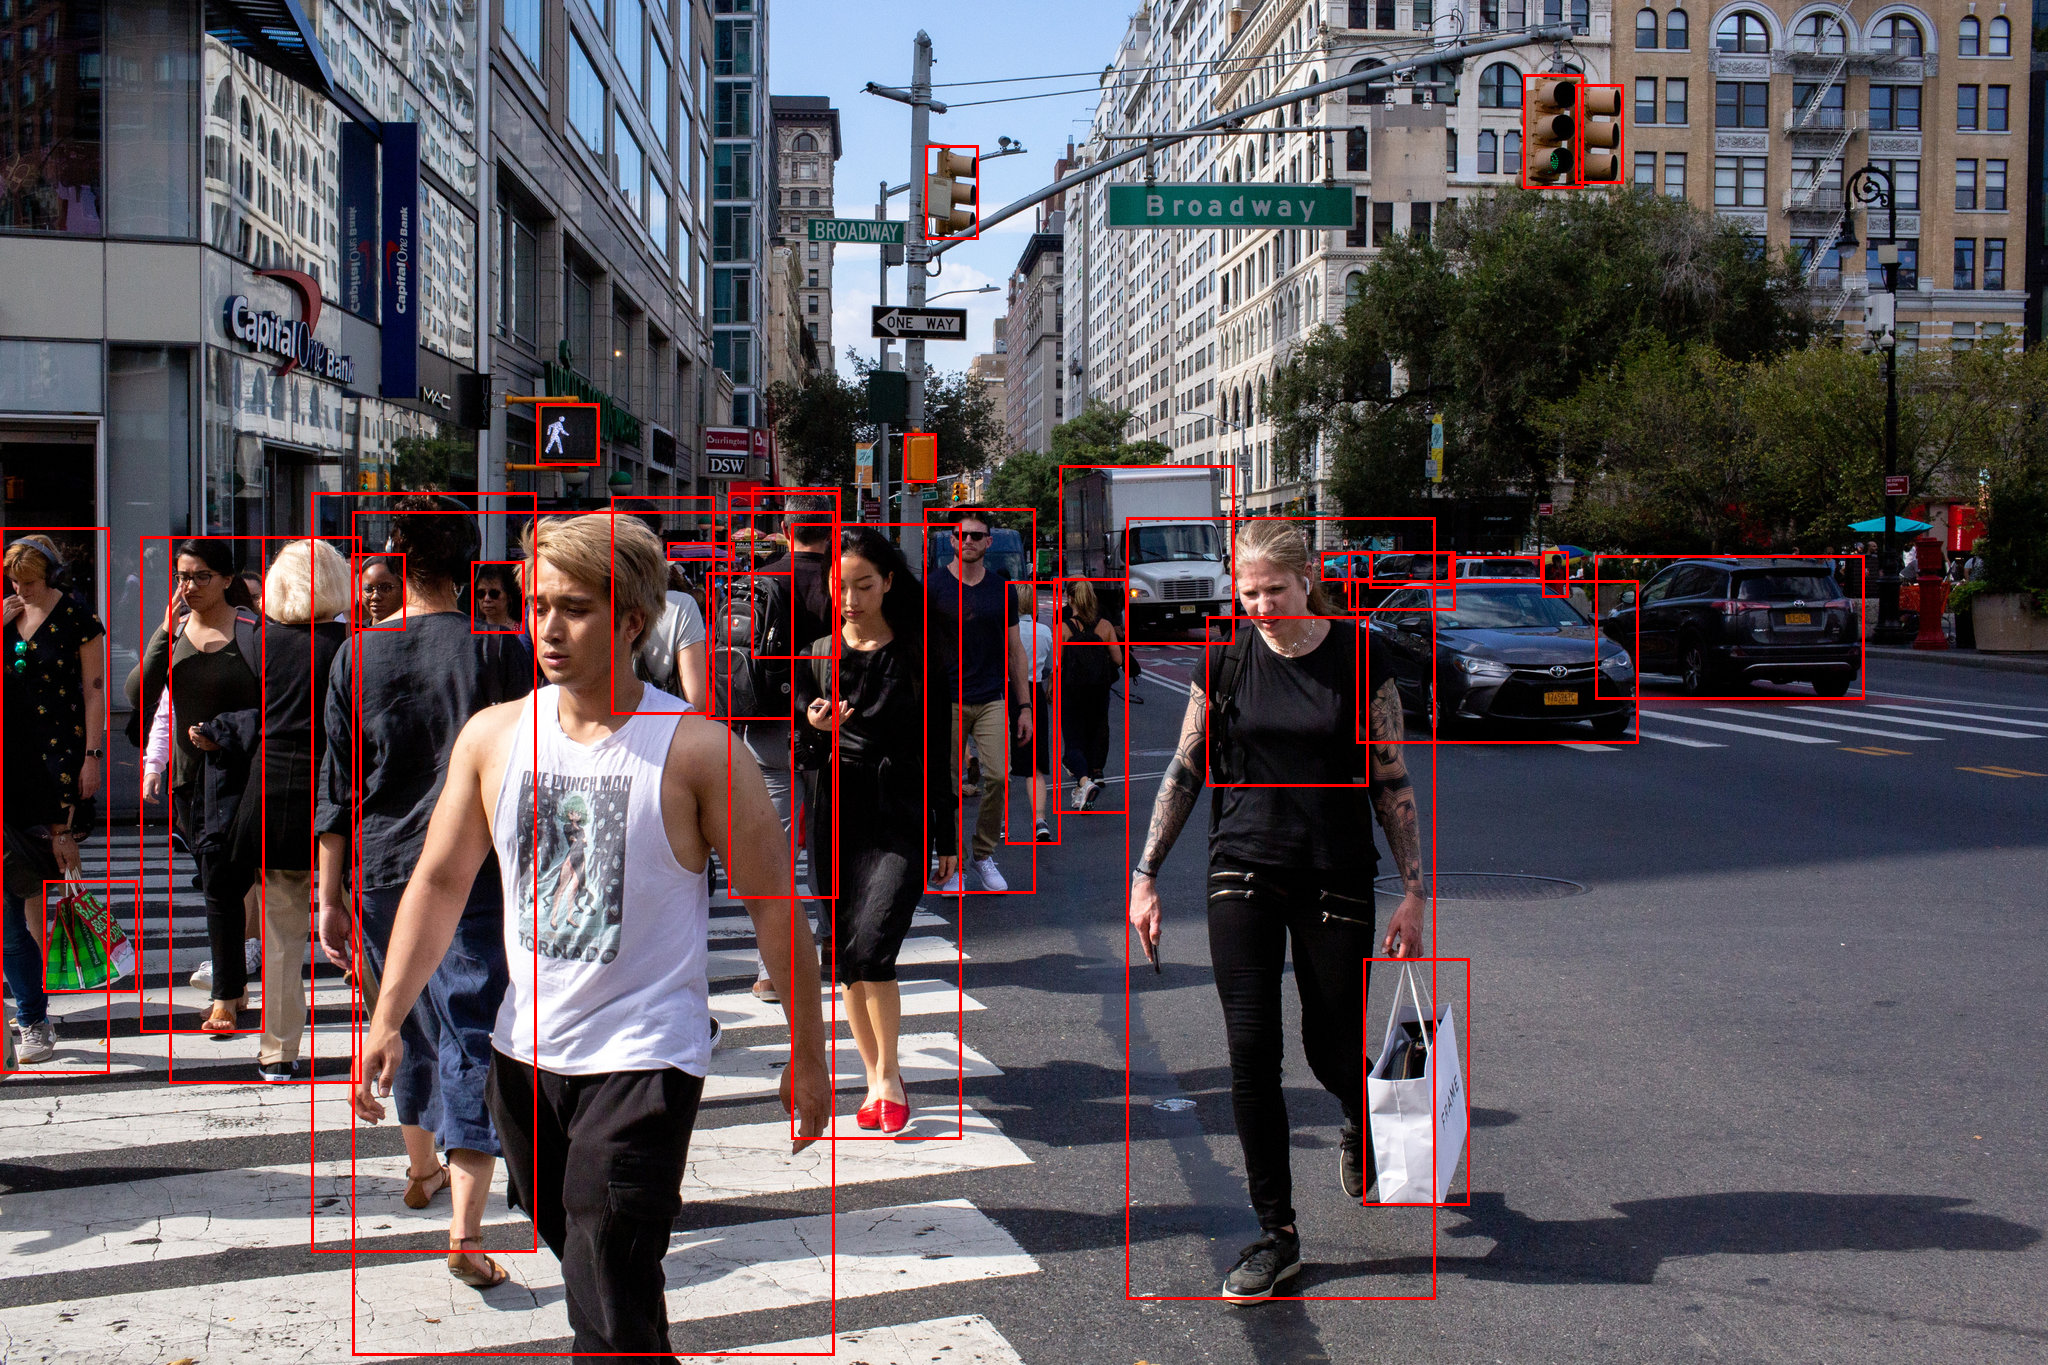

In [ ]:
import time
import torch
from PIL import Image, ImageDraw
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

# -------------------------------
# 1. Device Selection
# -------------------------------
# For Faster-RCNN, the 'mps' backend is very poorly optimized, so we will use the 'cuda' in the cloud and 'cpu' on local.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# -------------------------------
# 2. Load the Pre-trained Model
# -------------------------------
# This downloads the official weights (pre-trained on COCO)
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone="DEFAULT")
model.to(device)
model.eval()

# -------------------------------
# 3. Prepare an Image and Transform
# -------------------------------
image_path = "data_source/SampleDataset/street-sample1.png"
image = Image.open(image_path).convert("RGB")

transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).to(device)

# -------------------------------
# 4. Run Inference and Time It
# -------------------------------
with torch.no_grad():
    start_time = time.time()
    # The model expects a list of tensors, one per image.
    predictions = model([image_tensor])
    end_time = time.time()

elapsed_time = end_time - start_time
print(f"Inference time: {elapsed_time:.4f} seconds")

# -------------------------------
# 5. Process and Visualize Predictions
# -------------------------------
# Get the predictions for the first image
pred = predictions[0]
boxes = pred["boxes"]
scores = pred["scores"]
labels = pred["labels"]

# Define a confidence threshold
threshold = 0.7
draw = ImageDraw.Draw(image)

print("Detections:")
for box, score, label in zip(boxes, scores, labels):
    if score >= threshold:
        # Print the detected label, score, and bounding box
        print(f"Label: {label.item()}, Score: {score.item():.3f}, Box: {box.tolist()}")
        # Draw the bounding box on the image (red outline)
        draw.rectangle(box.tolist(), outline="red", width=3)

# Show the image with detections.
from PIL import Image
from IPython.core.display import display

display(image)


## Test base model on dataset

Now attempt to make a prediction using one of our brain tumor images, see if it can detect anything; it shouldn't be able to.

Inference time: 0.8153 seconds
Detections:


/var/folders/kd/sn90g5rn3j78k5hhy6jqx_pm0000gn/T/ipykernel_24876/4185451528.py:45: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


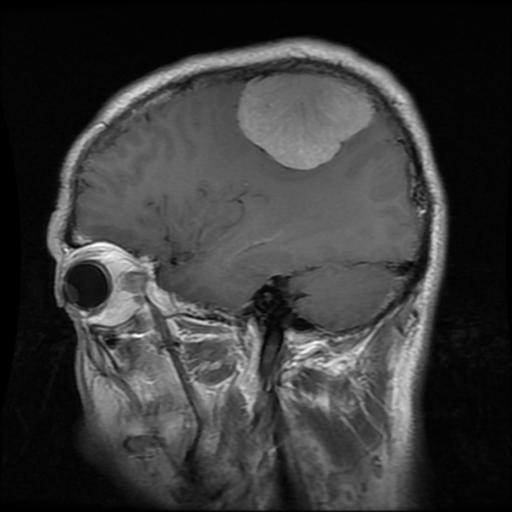

In [ ]:
# -------------------------------
# 1. Prepare an Image and Transform
# -------------------------------
image_path = "./datasets/raw/raw/meningioma/Tr-me_0547.jpg"
image = Image.open(image_path).convert("RGB")

transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).to(device)

# -------------------------------
# 2. Run Inference and Time It
# -------------------------------
with torch.no_grad():
    start_time = time.time()
    # The model expects a list of tensors, one per image.
    predictions = model([image_tensor])
    end_time = time.time()

elapsed_time = end_time - start_time
print(f"Inference time: {elapsed_time:.4f} seconds")

# -------------------------------
# 3. Process and Visualize Predictions
# -------------------------------
# Get the predictions for the first image
pred = predictions[0]
boxes = pred["boxes"]
scores = pred["scores"]
labels = pred["labels"]

# Define a confidence threshold
threshold = 0.7
draw = ImageDraw.Draw(image)

print("Detections:")
for box, score, label in zip(boxes, scores, labels):
    if score >= threshold:
        # Print the detected label, score, and bounding box
        print(f"Label: {label.item()}, Score: {score.item():.3f}, Box: {box.tolist()}")
        # Draw the bounding box on the image (red outline)
        draw.rectangle(box.tolist(), outline="red", width=3)

# Show the image with detections.
from PIL import Image
from IPython.core.display import display

display(image)

## Fine-tune the model

Here we will fine-tune the model on the dataset.
All the training here below was performed on Google Colab, because the local computer was not powerful enough to handle the training, so you won't see any output here.

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import torchvision.transforms as T
import torchvision
from tqdm.auto import tqdm
import logging
from torch.utils.tensorboard import SummaryWriter

# -----------------------------------------------------------------------------
# Setup logging to print info messages to the console.
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")

# -----------------------------------------------------------------------------
# 1. Custom Dataset for YOLO-Formatted Data (for Faster R-CNN)
# -----------------------------------------------------------------------------
class BrainTumorDataset(Dataset):
    """
    Expects a directory structure like:

        dataset_dir/
            training/
                images/       (e.g., image1.jpg, image2.jpg, ...)
                labels/       (e.g., image1.txt, image2.txt, ...)
            testing/
                images/
                labels/

    Each label file should contain one or more lines formatted as:
        <class> <x_center> <y_center> <width> <height>
    (all coordinates are normalized to [0, 1]).

    For Faster R-CNN we convert these to absolute pixel coordinates
    in the format [xmin, ymin, xmax, ymax].
    """
    def __init__(self, dataset_dir, split="training", transforms=None):
        self.dataset_dir = dataset_dir
        self.split = split
        self.images_dir = os.path.join(dataset_dir, split, "images")
        self.labels_dir = os.path.join(dataset_dir, split, "labels")
        self.image_files = sorted(
            [f for f in os.listdir(self.images_dir)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        )
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        # Read the corresponding label file
        label_filename = os.path.splitext(image_filename)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_filename)
        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # Skip malformed lines
                    # YOLO format: class, x_center, y_center, width, height (normalized)
                    cls = int(parts[0])
                    x_center, y_center, w, h = map(float, parts[1:])
                    # Convert normalized values to absolute pixel coordinates
                    x_center_abs = x_center * width
                    y_center_abs = y_center * height
                    w_abs = w * width
                    h_abs = h * height
                    xmin = x_center_abs - w_abs / 2
                    ymin = y_center_abs - h_abs / 2
                    xmax = x_center_abs + w_abs / 2
                    ymax = y_center_abs + h_abs / 2
                    boxes.append([xmin, ymin, xmax, ymax])
                    # Remap class: if original class is 0 for tumor, then tumor becomes label 1.
                    labels.append(cls + 1)
        # Convert lists to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.numel() == 0:
            # Force an empty 2D shape of (0,4)
            boxes = boxes.view(0, 4)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        # Apply transforms if provided; otherwise convert image to tensor.
        if self.transforms is not None:
            image = self.transforms(image)
        else:
            image = T.ToTensor()(image)

        return image, target

# Collate function for detection models. It simply bundles items as tuples.
def collate_fn(batch):
    return tuple(zip(*batch))

# -----------------------------------------------------------------------------
# 2. Load the Pre-trained Faster R-CNN Model and Adjust the Head
# -----------------------------------------------------------------------------
num_classes = 5

from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained Faster R-CNN model (pre-trained on COCO)
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the box predictor head and layer4
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

    if "rpn.head.conv" in name or "rpn.head.cls_logits" in name or "rpn.head.bbox_pred" in name:
        param.requires_grad = True

for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

# Device selection, no mps because it's not yet supported.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
logging.info(f"Using device: {device}")

# -----------------------------------------------------------------------------
# 3. Prepare DataLoader and Optimizer
# -----------------------------------------------------------------------------
dataset_dir = "./processed_split"
# dataset_dir = "./processed_augmented" # uncomment and comment above line to use augmented dataset

# Define any transforms; here we simply convert to tensor.
train_transforms = T.Compose([T.ToTensor()])
train_dataset = BrainTumorDataset(dataset_dir, split="training", transforms=train_transforms)
logging.info(f"Found {len(train_dataset)} training samples.")
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Only parameters that require gradients (i.e. the box predictor head) will be passed to the optimizer.
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir="training_logs")

# -----------------------------------------------------------------------------
# 4. Training Loop with Progress Bar and Logging
# -----------------------------------------------------------------------------

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    logging.info(f"Model saved at: {path}")

num_epochs = 50
logging.info("Starting training...")
global_step = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    logging.info(f"Epoch {epoch+1}/{num_epochs} starting...")
    # Create a tqdm progress bar over the DataLoader
    pbar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for batch_idx, (images, targets) in enumerate(train_dataloader):
        # Move images and targets to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        loss_value = losses.item()
        running_loss += loss_value

        writer.add_scalar("Loss/Batch", loss_value, global_step)
        global_step += 1

        # Log batch loss
        logging.info(f"Epoch {epoch+1} Batch {batch_idx+1}/{len(train_dataloader)} Loss: {loss_value:.4f}")
        pbar.update(1)
        pbar.set_postfix(loss=f"{loss_value:.4f}")

    pbar.close()
    avg_loss = running_loss / len(train_dataloader) if len(train_dataloader) > 0 else float('nan')
    writer.add_scalar("Loss/Epoch", avg_loss, epoch+1)
    if (epoch + 1) % 5 == 0:
        file_name = f"/content/drive/MyDrive/Final Project/fine_tuned_models/frcnn/frcnn_{epoch+1}.pth"
        save_model(model, file_name)
    logging.info(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

writer.close()

# -----------------------------------------------------------------------------
# 5. Save the Fine-Tuned Model
# -----------------------------------------------------------------------------
file_path = "/content/drive/MyDrive/Final Project/fine_tuned_models/frcnn/frcnn_final.pth"
save_model(model, file_path)


2025-02-08 15:01:53,420 INFO: Using device: cpu
2025-02-08 15:01:53,422 INFO: Found 1740 training samples.
2025-02-08 15:01:53,423 INFO: Starting training...
2025-02-08 15:01:53,423 INFO: Epoch 1/5 starting...


backbone.body.conv1.weight: False
backbone.body.bn1.weight: False
backbone.body.bn1.bias: False
backbone.body.layer1.0.conv1.weight: False
backbone.body.layer1.0.bn1.weight: False
backbone.body.layer1.0.bn1.bias: False
backbone.body.layer1.0.conv2.weight: False
backbone.body.layer1.0.bn2.weight: False
backbone.body.layer1.0.bn2.bias: False
backbone.body.layer1.0.conv3.weight: False
backbone.body.layer1.0.bn3.weight: False
backbone.body.layer1.0.bn3.bias: False
backbone.body.layer1.0.downsample.0.weight: False
backbone.body.layer1.0.downsample.1.weight: False
backbone.body.layer1.0.downsample.1.bias: False
backbone.body.layer1.1.conv1.weight: False
backbone.body.layer1.1.bn1.weight: False
backbone.body.layer1.1.bn1.bias: False
backbone.body.layer1.1.conv2.weight: False
backbone.body.layer1.1.bn2.weight: False
backbone.body.layer1.1.bn2.bias: False
backbone.body.layer1.1.conv3.weight: False
backbone.body.layer1.1.bn3.weight: False
backbone.body.layer1.1.bn3.bias: False
backbone.body.laye

Epoch 1/5:   0%|          | 0/870 [00:00<?, ?it/s]

KeyboardInterrupt: 

But just so you can see, here's the output from colab:

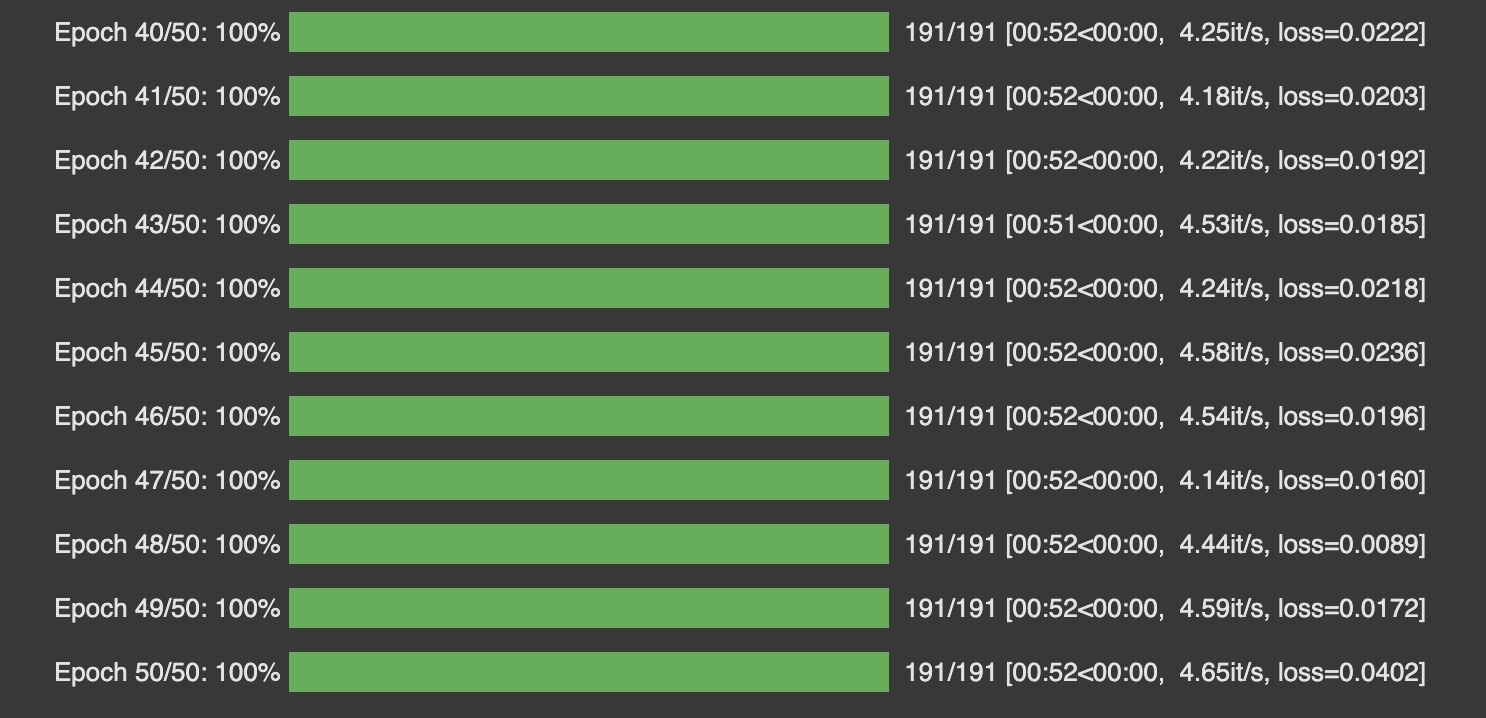

### Test the fine-tuned model

This will now test the fine-tuned model on the same image as before, and see if it can detect the tumor.

/var/folders/kd/sn90g5rn3j78k5hhy6jqx_pm0000gn/T/ipykernel_24876/3881850818.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_

Inference time: 0.8479 seconds
Detections:
Label: meningioma, Score: 1.000, Box: [234.53135681152344, 73.4718246459961, 378.32537841796875, 175.90151977539062]


/var/folders/kd/sn90g5rn3j78k5hhy6jqx_pm0000gn/T/ipykernel_24876/3881850818.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


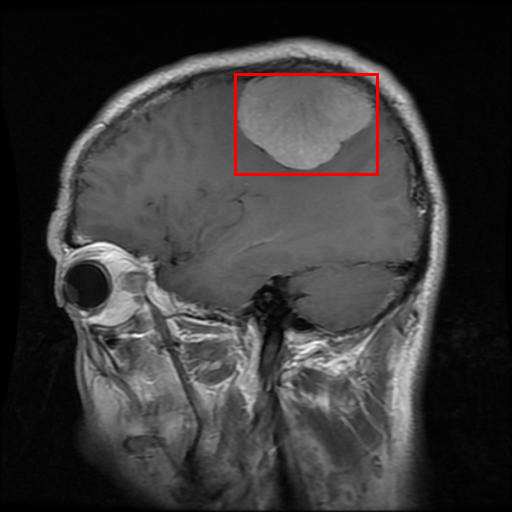

In [ ]:
import time
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------
# 1. Create basic model structure
# -------------------------------
num_classes = 5
model = fasterrcnn_resnet50_fpn_v2(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# -------------------------------
# 2. Load the state_dict
# -------------------------------
checkpoint_path = "./models/FRCNN/frcnn_100-augmented.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))

# -------------------------------
# 3. Align device
# -------------------------------
device = torch.device("cpu")
model.to(device)

# -------------------------------
# 4. For inference, set model to eval mode
# -------------------------------
model.eval()

# -------------------------------
# 5. Prepare an Image and Transform
# -------------------------------
image_path = "./datasets/raw/raw/meningioma/Tr-me_0547.jpg"
image = Image.open(image_path).convert("RGB")

# Define a simple transform: convert PIL image to tensor.
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).to(device)

# -------------------------------
# 6. Run Inference and Time It
# -------------------------------
with torch.no_grad():
    start_time = time.time()
    predictions = model([image_tensor])
    end_time = time.time()

elapsed_time = end_time - start_time
print(f"Inference time: {elapsed_time:.4f} seconds")

# -------------------------------
# 7. Process and Visualize Predictions
# -------------------------------
# Get the predictions for the first image
pred = predictions[0]
boxes = pred["boxes"]
scores = pred["scores"]
labels = pred["labels"]

threshold = 0.2
draw = ImageDraw.Draw(image)

class_names = {
    1: "pituitary",
    2: "meningioma",
    3: "glioma",
    4: "no_tumor"
}

print("Detections:")
for box, score, label in zip(boxes, scores, labels):
    if score >= threshold:
        cls_name = class_names[label.item()]
        print(f"Label: {cls_name}, Score: {score:.3f}, Box: {box.tolist()}")
        # Draw the bounding box on the image (red outline)
        draw.rectangle(box.tolist(), outline="red", width=3)

from PIL import Image
from IPython.core.display import display

display(image)